In [2]:
import os
import pickle

import numpy as np
import pandas as pd
from gensim.models.doc2vec import Doc2Vec
import gensim
from scipy import stats
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('white')
sns.set_context('paper')
# Plot adjustments:
plt.rcParams.update({'ytick.labelsize': 12})
plt.rcParams.update({'xtick.labelsize': 12})
plt.rcParams.update({'axes.labelsize': 12})
plt.rcParams.update({'legend.fontsize': 30})
plt.rcParams.update({'axes.titlesize': 16})

import embedding_tools

import gpm
import gpk

assert gensim.__version__ == '1.0.1'
assert np.__version__ == '1.13.1'
assert pd.__version__ == '0.20.3'

In [3]:
dfs = {}
dfs['log_GFP'] = pd.read_csv('../inputs/localization.txt')
dfs['peak'] = pd.read_csv('../inputs/absorption.txt')
dfs['T50'] = pd.read_csv('../inputs/T50.txt')
dfs['e-value'] = pd.read_csv('../inputs/enantioselectivity.txt')

dirs = {}
dirs['peak'] = '../outputs/absorption_scrambled_embeddings/'
dirs['T50'] = '../outputs/T50_scrambled_embeddings/'
dirs['e-value'] = '../outputs/enantioselectivity_scrambled_embeddings/'
dirs['log_GFP'] = '../outputs/localization_scrambled_embeddings/'


tasks = ('log_GFP', 'peak', 'T50', 'e-value')
hypers = [('scrambled', 3, 5), ('uniform', 4, 1), ('original', 3, 7), ('random', 3, 7)]
model_dir = '../outputs/docvec_models/'

## Infer from scrambled training sequences

In [3]:
def infer_vectors(df, model, k, dest, overlap=False, method=None):       
    seqs = embedding_tools.get_seqs(df)
    if method is not None:
        seqs = embedding_tools.randomize_seqs(seqs, method=method)
    embeds = embedding_tools.get_embeddings_new(model, seqs, k=k,
                                                overlap=overlap)
    embeds = pd.DataFrame(embeds, index=df.name)
    terms = list(range(embeds.shape[1]))
    name = model.split('/')[-1]
    with open(dest + 'X_' + name, 'wb') as f:
        pickle.dump((embeds, terms), f)
        
models = os.listdir(model_dir + 'new_models/')
models = [m for m in models if m[-3:] == 'pkl']

for i, t in enumerate(tasks):
    Xs = os.listdir(dirs[t] + dest)
    name = '_'.join([str(h) for h in hypers[i]])
    for model in models:
        if name not in model:
            continue
        if 'X_' + model in Xs:
            continue
        print('Model ' + model + ' for dataset ' + t + ':')
        k = int(model.split('_')[1])
        print('Inferring...')
        %time infer_vectors(dfs[t], model_dir + model, k, dirs[t], method=0)
        print('Success!')

In [7]:
def select_X_and_Y(df, all_X, y_column):
    not_dropped = ~pd.isnull(df[y_column])
    not_dropped = pd.Series(not_dropped, index=df.index)
    Ys = df[not_dropped][y_column]
    Ys.index = df[not_dropped]['name']
    Xs = all_X.loc[Ys.index]
    return Xs, Ys

def score(Y, pred_Y, pred_var):
    r1 = stats.rankdata(Y)
    r2 = stats.rankdata(pred_Y)
    scores = {}
    scores['kendalltau'] = stats.kendalltau(r1, r2).correlation
    scores['R2'] = metrics.r2_score(Y, pred_Y)
    scores['mae'] = metrics.mean_absolute_error(Y, pred_Y)
    scores['SE'] = metrics.mean_squared_error(Y, pred_Y)
    scores['R'] = np.corrcoef(Y, pred_Y)[0, 1]
    log_ps = -0.5 * np.log(pred_var) - (pred_Y - Y)**2 / 2 / pred_var
    log_ps -= 0.5 * np.log(2 * np.pi)
    scores['log_loss'] = -np.sum(log_ps)
    return scores

def evaluate(df_train, df_test, X, task, X_name, guesses=None, kernel='matern'):
    X_train, y_train = select_X_and_Y(df_train, X, task)
    X_test, y_test = select_X_and_Y(df_test, X, task)
    n_train, d = X_train.shape
    n_test, d = X_test.shape
    if kernel == 'matern':
        k = gpk.MaternKernel('5/2')
    if kernel == 'cubic':
        k = gpk.PolynomialKernel(3)
    clf = gpm.GPRegressor(k, guesses=guesses)
    clf.fit(X_train, y_train)
    print(X_name)
    print(clf.hypers)
    mu, var = clf.predict(X_test)
    met1 = score(y_test, mu, np.diag(var))
    met1['task'] = task
    met1['X'] = X_name
    met1['n_train'] = n_train
    met1['n_test'] = n_test
    met1['kernel'] = kernel
    met1 = pd.DataFrame(met1, index=[0])
    return met1, mu

log_GFP
X_scrambled_3_5
[ 0.92093774  2.86425647]
peak
X_uniform_4_1
[   1.015901   336.4147892]
T50
X_original_3_7
[ 0.32359132  0.88447538]
e-value
X_random_3_7
[   1.00734238  241.81086924]


,R,R2,SE,X,kendalltau,kernel,log_loss,mae,n_test,n_train,task
0,0.261559,-0.067078,1.842776,X_scrambled_3_5,0.159091,matern,57.374260,1.121766,33,215,log_GFP
1,0.082892,-0.370402,4129.578977,X_uniform_4_1,-0.029588,matern,162.062746,61.436345,19,62,peak
2,0.535205,-0.074448,35.126059,X_original_3_7,0.311770,matern,61.755192,4.485086,19,242,T50
3,0.279247,-22.199225,1908.926370,X_random_3_7,0.266215,matern,84.720237,42.739284,16,136,e-value


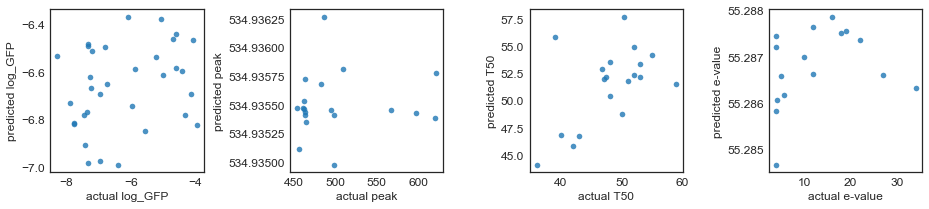

In [14]:
fname = '../outputs/scrambled_test.txt'
res = pd.DataFrame(index=[])
fig, axs = plt.subplots(1, 4, figsize=(13, 3))

for i, t in enumerate(tasks):
    print(t)
    df = dfs[t]
    e_dir = dirs[t]
    df_test = df[~df.is_train]
    df_train = df[df.is_train]
    y_test = df_test.dropna(subset=[t])[t]

    # Embedding
    Xs = os.listdir(e_dir)
    for emb in Xs:
        if emb[-3:] != 'pkl':
            continue
        with open(e_dir + emb, 'rb')  as f:
            X = pickle.load(f)
        if len(X) == 2:
            X = X[0]
        evals, mu = evaluate(df_train, df_test, X, t, emb[:-4], guesses=(0.1, 10))
        res = pd.concat((res, evals), ignore_index=True)
        axs[i].plot(y_test, mu, 'o', alpha=0.8)
        axs[i].set_xlabel('actual ' + t)
        axs[i].set_ylabel('predicted ' + t)
        axs[i].get_yaxis().get_major_formatter().set_useOffset(False)

fig.tight_layout()

res.to_csv(fname, index=False)
res.head()

## Scramble the labels

/Users/kevinyang/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


X_scrambled_3_5
[   1.0046072   127.07701047]
X_uniform_4_1
[   1.01609551  182.31881209]
X_original_3_7
[ 0.97094979  5.37301353]
X_random_3_7
[   1.00713923  224.87865161]


,R,R2,SE,X,kendalltau,kernel,log_loss,mae,n_test,n_train,task
0,0.234866,-0.126551,1.945482,X_scrambled_3_5,0.219697,matern,58.313649,1.160039,33,215,log_GFP
1,0.332735,-0.370390,4129.544411,X_uniform_4_1,0.230785,matern,162.044695,61.436148,19,62,peak
2,-0.110954,-0.540572,50.364656,X_original_3_7,-0.052942,matern,65.090355,5.394388,19,242,T50
3,0.327487,-22.199168,1908.921612,X_random_3_7,0.352090,matern,84.721415,42.739252,16,136,e-value


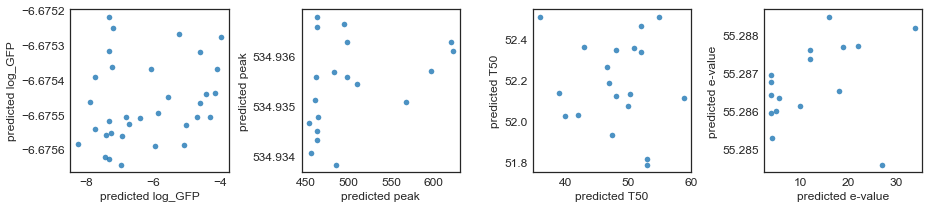

In [16]:
fname = '../outputs/scrambled_label_test.txt'
res = pd.DataFrame(index=[])
fig, axs = plt.subplots(1, 4, figsize=(13, 3))

edirs = {
    'peak': '../outputs/absorption_embeddings/',
    'T50': '../outputs/T50_embeddings/',
    'log_GFP': '../outputs/localization_embeddings/',
    'e-value': '../outputs/enantioselectivity_embeddings/'
}

for i, t in enumerate(tasks):
    df = dfs[t]
    e_dir = dirs[t]
    df_test = df[~df.is_train]
    df_train = df[df.is_train]
    y_test = df_test.dropna(subset=[t])[t]

    y = df_train[t].values
    np.random.seed(11)
    np.random.shuffle(y)
    df_train[t] = y
    # Embedding
    embedding_name = 'X_' + '_'.join([str(h) for h in hypers[i]]) + '.pkl'
    with open(e_dir + embedding_name, 'rb')  as f:
        X = pickle.load(f)
    if len(X) == 2:
        X = X[0]
    evals, mu = evaluate(df_train, df_test, X, t, embedding_name[:-4], guesses=(0.1, 10))
    res = pd.concat((res, evals), ignore_index=True)
    axs[i].plot(y_test, mu, 'o', alpha=0.8)
    axs[i].set_xlabel('predicted ' + t)
    axs[i].set_ylabel('predicted ' + t)
    axs[i].get_yaxis().get_major_formatter().set_useOffset(False)
_ = fig.tight_layout()
res.to_csv(fname, index=False)
res.head()

## Data sequences only

X_ChR_data_5_7
[ 0.48780464  0.10627054]


,R,R2,SE,X,kendalltau,kernel,log_loss,mae,n_test,n_train,task
0,0.806639,0.469831,0.915568,X_ChR_data_5_7,0.564394,matern,46.643668,0.783974,33,215,log_GFP


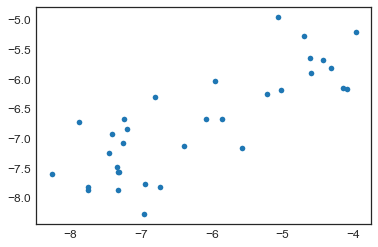

In [17]:
y_col = 'log_GFP'
df = dfs[y_col]
embedding_dirs = edirs[y_col]
emb = 'X_ChR_data_5_7.pkl'
df_test = df[~df.is_train]
df_train = df[df.is_train]
y_test = df_test.dropna(subset=[y_col])[y_col]


# Embedding
with open(embedding_dirs + emb, 'rb')  as f:
    X, _ = pickle.load(f)
evals, mu = evaluate(df_train, df_test, X, y_col, emb[:-4], guesses=(0.1, 10))
_ = plt.plot(y_test, mu, 'o')
evals

X_peak_data_3_4
[ 1.01524878  9.9996485 ]


,R,R2,SE,X,kendalltau,kernel,log_loss,mae,n_test,n_train,task
0,0.508466,-0.370007,4128.389678,X_peak_data_3_4,0.337302,matern,162.051579,61.426757,19,62,peak


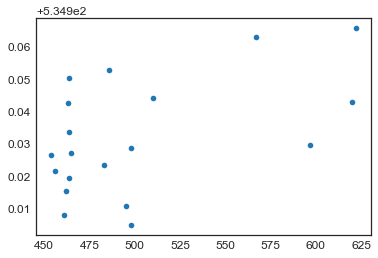

In [21]:
y_col = 'peak'
df = dfs[y_col]
e_dir = edirs[y_col]
df_test = df[~df.is_train]
df_train = df[df.is_train]
emb = 'X_peak_data_3_4.pkl'



# Embedding
with open(e_dir + emb, 'rb')  as f:
    X = pickle.load(f)
evals, mu = evaluate(df_train, df_test, X, y_col, emb[:-4], guesses=(0.1, 10))
y_test = df_test.dropna(subset=[y_col])[y_col]
_ = plt.plot(y_test, mu, 'o')

evals

X_P450_data_2_3
[ 0.10195    0.1014413]


,R,R2,SE,X,kendalltau,kernel,log_loss,mae,n_test,n_train,task
0,0.541474,-0.218482,39.834844,X_P450_data_2_3,0.452949,matern,63.317695,5.021208,19,242,T50


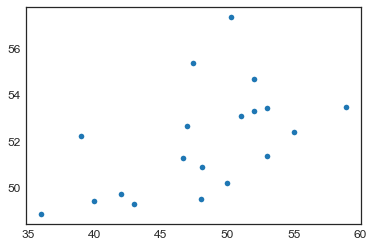

In [23]:
y_col = 'T50'
df = dfs[y_col]
e_dir = edirs[y_col]
df_test = df[~df.is_train]
df_train = df[df.is_train]
emb = 'X_P450_data_2_3.pkl'


with open(e_dir + emb, 'rb')  as f:
    X, _ = pickle.load(f)
evals, mu = evaluate(df_train, df_test, X, y_col, emb[:-4], guesses=(0.1, 10))
y_test = df_test.dropna(subset=[y_col])[y_col]
_ = plt.plot(y_test, mu, 'o')
evals

X_aneh_data_4_2
[ 0.19002749  0.13107885]


,R,R2,SE,X,kendalltau,kernel,log_loss,mae,n_test,n_train,task
0,-0.0925,-0.361997,4104.25156,X_aneh_data_4_2,-0.041423,matern,169.954553,60.694635,19,62,peak


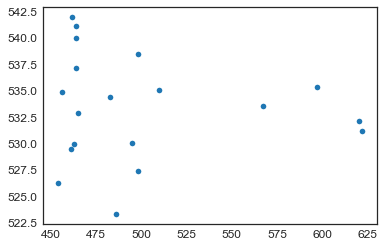

In [24]:
y_col = 'e-value'
emb = 'X_aneh_data_4_2.pkl'
y_col = 'peak'
df = dfs[y_col]
e_dir = edirs[y_col]
df_test = df[~df.is_train]
df_train = df[df.is_train]

with open(e_dir + emb, 'rb')  as f:
    X = pickle.load(f)
evals, mu = evaluate(df_train, df_test, X, y_col, emb[:-4], guesses=(10, 10))
y_test = df_test.dropna(subset=[y_col])[y_col]
_ = plt.plot(y_test, mu, 'o')
evals